# Time-series Forecasting

## Description
The data consists of 52,416 observations of energy consumption on a 10-minute window. Every observation is described by the following feature columns.

Your task is to **aggregate the observations on an interval of 2 hours**. For this time interval, using the values of the **4 previous time intervals**, forecast the target value one step in the future. Choose which features you are going to use.

**You must train a Boosting model for the task. Choose the model based on the number, and type of features available.**



Features:

* Date: Time window of ten minutes.
* Temperature: Weather Temperature.
* Humidity: Weather Humidity.
* WindSpeed: Wind Speed.
* GeneralDiffuseFlows: “Diffuse flow” is a catchall term to describe low-temperature (< 0.2° to ~ 100°C) fluids that slowly discharge through sulfide mounds, fractured lava flows, and assemblages of bacterial mats and macrofauna.
* DiffuseFlows

Target:

SolarPower

## Dataset links:
* [DS1](https://drive.google.com/file/d/1-Pcpb1xWpKc8Cgs-P7xqBFHw2NM0dBsA/view?usp=sharing)
* [DS2](https://drive.google.com/file/d/1-Pul07w6LXpm-uo99qbNc86FHhwl4yQD/view?usp=sharing)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Read the datasets

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import numpy as np
import keras
from keras.layers import Input, Dense, LSTM, Embedding, concatenate
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [3]:
solar_power_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/power_consumption_g3.csv')
info_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/power_consumption_g3_feat.csv')
solar_power_data.head()


,Date,SolarPower
0,2017-06-22 11:50:00,35818.80795
1,2017-04-24 22:50:00,34628.20237
2,2017-11-05 09:00:00,22781.53846
3,2017-10-19 23:20:00,31925.77681
4,2017-03-25 17:10:00,30246.12766


## Merge the datasets (and pre-processing if needed)

In [4]:
info_data['Date'] = pd.to_datetime(info_data['Date'])
info_data = info_data.set_index('Date')



In [5]:
solar_power_data['Date'] = pd.to_datetime(solar_power_data['Date'])
solar_power_data = solar_power_data.set_index('Date')

In [6]:
data = info_data.merge(solar_power_data, how='left', right_index=True, left_index=True)

In [7]:
data

,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows,SolarPower
Date,,,,,,
2017-03-01 16:40:00,21.33,55.91,0.080,387.400,427.300,32243.74468
2017-07-27 06:30:00,23.10,48.58,4.908,10.450,8.630,26356.94352
2017-10-11 19:00:00,23.10,59.82,0.084,0.446,0.322,46962.27571
2017-02-10 06:50:00,12.25,80.80,4.916,0.051,0.111,22173.55932
2017-03-06 16:00:00,15.62,59.38,0.075,533.400,579.900,33328.34043
...,...,...,...,...,...,...
2017-05-14 02:20:00,23.58,43.10,0.075,0.110,0.122,23808.00000
2017-11-17 19:20:00,17.30,76.50,0.075,0.040,0.148,37796.92308
2017-03-21 12:10:00,17.90,50.28,0.081,837.000,296.700,31692.25532


## Group the datasets into time intervals of 2 hours

In [11]:
#df_new = data.resample('120Min').mean()
df=data.copy()

## Create lags

In [12]:
df.isnull().sum()

Temperature            559
Humidity               499
WindSpeed              529
GeneralDiffuseFlows    524
DiffuseFlows           505
SolarPower               0
dtype: int64

In [13]:
df.columns

Index(['Temperature', 'Humidity', 'WindSpeed', 'GeneralDiffuseFlows',
       'DiffuseFlows', 'SolarPower'],
      dtype='object')

In [15]:
from sklearn.impute import KNNImputer

In [16]:
knn=KNNImputer(n_neighbors=5)

In [17]:
cols=['Temperature', 'Humidity', 'WindSpeed', 'GeneralDiffuseFlows',
       'DiffuseFlows']

In [18]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()

In [19]:
scaleData=scaler.fit_transform(df[cols])

In [21]:
imputedData=knn.fit_transform(scaleData)

In [22]:
df[cols]=scaler.inverse_transform(imputedData)

In [23]:
df.isnull().sum()

Temperature            0
Humidity               0
WindSpeed              0
GeneralDiffuseFlows    0
DiffuseFlows           0
SolarPower             0
dtype: int64

In [24]:
df

,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows,SolarPower
Date,,,,,,
2017-03-01 16:40:00,21.33,55.91,0.080,387.400,427.300,32243.74468
2017-07-27 06:30:00,23.10,48.58,4.908,10.450,8.630,26356.94352
2017-10-11 19:00:00,23.10,59.82,0.084,0.446,0.322,46962.27571
2017-02-10 06:50:00,12.25,80.80,4.916,0.051,0.111,22173.55932
2017-03-06 16:00:00,15.62,59.38,0.075,533.400,579.900,33328.34043
...,...,...,...,...,...,...
2017-05-14 02:20:00,23.58,43.10,0.075,0.110,0.122,23808.00000
2017-11-17 19:20:00,17.30,76.50,0.075,0.040,0.148,37796.92308
2017-03-21 12:10:00,17.90,50.28,0.081,837.000,296.700,31692.25532


In [33]:
df_new=df.copy()

In [34]:
df_new = df.resample('120Min').mean()

In [36]:
df_new

,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows,SolarPower
Date,,,,,,
2017-01-01 00:00:00,6.548750,76.126500,0.081917,0.060167,0.105667,26927.594937
2017-01-01 02:00:00,5.029333,78.008333,0.082583,0.061417,0.135083,21447.088607
2017-01-01 04:00:00,4.919667,74.641667,0.081667,0.061917,0.120833,20641.518987
2017-01-01 06:00:00,4.512750,74.575000,0.082417,0.063583,0.122500,20094.683545
2017-01-01 08:00:00,4.632167,73.791667,0.082417,79.281917,15.761833,21255.189872
...,...,...,...,...,...,...
2017-12-30 14:00:00,14.513333,40.599000,0.077667,409.650000,42.163333,29293.789606
2017-12-30 16:00:00,14.015000,45.720667,0.077500,153.905000,152.368333,31262.864386
2017-12-30 18:00:00,10.112500,61.449667,0.075583,1.618917,1.676750,37721.673005


In [37]:
tmp=df

In [38]:
df=df_new

In [39]:
df_new=tmp

In [40]:
df

,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows,SolarPower
Date,,,,,,
2017-01-01 00:00:00,6.548750,76.126500,0.081917,0.060167,0.105667,26927.594937
2017-01-01 02:00:00,5.029333,78.008333,0.082583,0.061417,0.135083,21447.088607
2017-01-01 04:00:00,4.919667,74.641667,0.081667,0.061917,0.120833,20641.518987
2017-01-01 06:00:00,4.512750,74.575000,0.082417,0.063583,0.122500,20094.683545
2017-01-01 08:00:00,4.632167,73.791667,0.082417,79.281917,15.761833,21255.189872
...,...,...,...,...,...,...
2017-12-30 14:00:00,14.513333,40.599000,0.077667,409.650000,42.163333,29293.789606
2017-12-30 16:00:00,14.015000,45.720667,0.077500,153.905000,152.368333,31262.864386
2017-12-30 18:00:00,10.112500,61.449667,0.075583,1.618917,1.676750,37721.673005


In [41]:
df.columns

Index(['Temperature', 'Humidity', 'WindSpeed', 'GeneralDiffuseFlows',
       'DiffuseFlows', 'SolarPower'],
      dtype='object')

In [42]:
cols=['Temperature', 'Humidity', 'WindSpeed', 'GeneralDiffuseFlows',
       'DiffuseFlows', 'SolarPower']

In [43]:
for i in range(4,0,-1):
  for c in cols:
    df[c+' day_'+str(i)]=df[c].shift(i)

In [44]:
# target = 'SolarPower'
# numeric_feature_df = df_new[]
# lags = 5

# for i in range(1, lags + 1):
#   for col in nfn:
#     df_new[f'{col}_lag_{i}'] = df_new[col].shift(i)

# df_new.head()

In [45]:
df

,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows,SolarPower,Temperature day_4,Humidity day_4,WindSpeed day_4,GeneralDiffuseFlows day_4,...,WindSpeed day_2,GeneralDiffuseFlows day_2,DiffuseFlows day_2,SolarPower day_2,Temperature day_1,Humidity day_1,WindSpeed day_1,GeneralDiffuseFlows day_1,DiffuseFlows day_1,SolarPower day_1
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-01 00:00:00,6.548750,76.126500,0.081917,0.060167,0.105667,26927.594937,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-01 02:00:00,5.029333,78.008333,0.082583,0.061417,0.135083,21447.088607,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,6.548750,76.126500,0.081917,0.060167,0.105667,26927.594937
2017-01-01 04:00:00,4.919667,74.641667,0.081667,0.061917,0.120833,20641.518987,NaN,NaN,NaN,NaN,...,0.081917,0.060167,0.105667,26927.594937,5.029333,78.008333,0.082583,0.061417,0.135083,21447.088607
2017-01-01 06:00:00,4.512750,74.575000,0.082417,0.063583,0.122500,20094.683545,NaN,NaN,NaN,NaN,...,0.082583,0.061417,0.135083,21447.088607,4.919667,74.641667,0.081667,0.061917,0.120833,20641.518987
2017-01-01 08:00:00,4.632167,73.791667,0.082417,79.281917,15.761833,21255.189872,6.548750,76.126500,0.081917,0.060167,...,0.081667,0.061917,0.120833,20641.518987,4.512750,74.575000,0.082417,0.063583,0.122500,20094.683545
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-30 14:00:00,14.513333,40.599000,0.077667,409.650000,42.163333,29293.789606,11.221667,50.971667,0.078417,0.062917,...,0.077000,353.441667,36.275833,29649.683142,14.399167,38.129167,0.077667,489.841667,38.455000,30490.240812
2017-12-30 16:00:00,14.015000,45.720667,0.077500,153.905000,152.368333,31262.864386,11.082500,48.224167,0.078083,76.933417,...,0.077667,489.841667,38.455000,30490.240812,14.513333,40.599000,0.077667,409.650000,42.163333,29293.789606
2017-12-30 18:00:00,10.112500,61.449667,0.075583,1.618917,1.676750,37721.673005,13.382500,43.325000,0.077000,353.441667,...,0.077667,409.650000,42.163333,29293.789606,14.015000,45.720667,0.077500,153.905000,152.368333,31262.864386


In [46]:
df=df.dropna(axis=0).reset_index()

In [47]:
df.isnull().sum()

Date                         0
Temperature                  0
Humidity                     0
WindSpeed                    0
GeneralDiffuseFlows          0
DiffuseFlows                 0
SolarPower                   0
Temperature day_4            0
Humidity day_4               0
WindSpeed day_4              0
GeneralDiffuseFlows day_4    0
DiffuseFlows day_4           0
SolarPower day_4             0
Temperature day_3            0
Humidity day_3               0
WindSpeed day_3              0
GeneralDiffuseFlows day_3    0
DiffuseFlows day_3           0
SolarPower day_3             0
Temperature day_2            0
Humidity day_2               0
WindSpeed day_2              0
GeneralDiffuseFlows day_2    0
DiffuseFlows day_2           0
SolarPower day_2             0
Temperature day_1            0
Humidity day_1               0
WindSpeed day_1              0
GeneralDiffuseFlows day_1    0
DiffuseFlows day_1           0
SolarPower day_1             0
dtype: int64

# Split the dataset into 80% training and 20% testing datasets

In [48]:
df.columns

Index(['Date', 'Temperature', 'Humidity', 'WindSpeed', 'GeneralDiffuseFlows',
       'DiffuseFlows', 'SolarPower', 'Temperature day_4', 'Humidity day_4',
       'WindSpeed day_4', 'GeneralDiffuseFlows day_4', 'DiffuseFlows day_4',
       'SolarPower day_4', 'Temperature day_3', 'Humidity day_3',
       'WindSpeed day_3', 'GeneralDiffuseFlows day_3', 'DiffuseFlows day_3',
       'SolarPower day_3', 'Temperature day_2', 'Humidity day_2',
       'WindSpeed day_2', 'GeneralDiffuseFlows day_2', 'DiffuseFlows day_2',
       'SolarPower day_2', 'Temperature day_1', 'Humidity day_1',
       'WindSpeed day_1', 'GeneralDiffuseFlows day_1', 'DiffuseFlows day_1',
       'SolarPower day_1'],
      dtype='object')

In [49]:
fea=['Temperature day_4', 'Humidity day_4',
       'WindSpeed day_4', 'GeneralDiffuseFlows day_4', 'DiffuseFlows day_4',
       'SolarPower day_4', 'Temperature day_3', 'Humidity day_3',
       'WindSpeed day_3', 'GeneralDiffuseFlows day_3', 'DiffuseFlows day_3',
       'SolarPower day_3', 'Temperature day_2', 'Humidity day_2',
       'WindSpeed day_2', 'GeneralDiffuseFlows day_2', 'DiffuseFlows day_2',
       'SolarPower day_2', 'Temperature day_1', 'Humidity day_1',
       'WindSpeed day_1', 'GeneralDiffuseFlows day_1', 'DiffuseFlows day_1',
       'SolarPower day_1']

In [51]:
X,Y=df[fea],df['SolarPower']

In [52]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2,shuffle=False)

In [53]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()

In [54]:
scaler.fit(X_train)

MinMaxScaler()

In [55]:
X_train=scaler.fit_transform(X_train)
X_test=scaler.fit_transform(X_test)

In [57]:
df.columns

Index(['Date', 'Temperature', 'Humidity', 'WindSpeed', 'GeneralDiffuseFlows',
       'DiffuseFlows', 'SolarPower', 'Temperature day_4', 'Humidity day_4',
       'WindSpeed day_4', 'GeneralDiffuseFlows day_4', 'DiffuseFlows day_4',
       'SolarPower day_4', 'Temperature day_3', 'Humidity day_3',
       'WindSpeed day_3', 'GeneralDiffuseFlows day_3', 'DiffuseFlows day_3',
       'SolarPower day_3', 'Temperature day_2', 'Humidity day_2',
       'WindSpeed day_2', 'GeneralDiffuseFlows day_2', 'DiffuseFlows day_2',
       'SolarPower day_2', 'Temperature day_1', 'Humidity day_1',
       'WindSpeed day_1', 'GeneralDiffuseFlows day_1', 'DiffuseFlows day_1',
       'SolarPower day_1'],
      dtype='object')

In [58]:
X_train=X_train.reshape(X_train.shape[0],4,6)
X_test=X_test.reshape(X_test.shape[0],4,6)

In [56]:
# df_new.dropna(inplace=True)
# numeric_feature_names = df_new.columns[6:]
# numeric_feature_names

# df_nmf = df_new[numeric_feature_names]
# text_feature_names = 'SolarPower'
# text_features = df_new[text_feature_names]

In [59]:
# target = 'SolarPower'
# Y = df_new[target]

## Create the model, pre-process the data and make it suitable for training

In [60]:
# X_train_numeric, X_test_numeric, Y_train, Y_test = train_test_split(df_nmf, Y, shuffle=False, test_size=0.2)
# X_train_text, X_test_text, _, _ = train_test_split(text_features, Y, shuffle=False, test_size=0.2)



In [61]:
# scaler = MinMaxScaler()
# X_train_numeric = scaler.fit_transform(X_train_numeric)
# X_test_numeric = scaler.transform(X_test_numeric)
# Y_train = scaler.fit_transform(Y_train.values.reshape(-1, 1))

## Perofrm hyper-parameter optimization with a 5-fold cross validation.

Important: Do not use many values for the hyper-parameters due to time constraints.

KEEP IN MIND THE DATASET IS TIME-SERIES.

In [63]:
from xgboost import XGBRegressor

In [64]:
model = XGBRegressor()

In [67]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

In [71]:
X_train.shape

(3491, 4, 6)

In [72]:
param_grid = {
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1],
    'n_estimators': [100, 200]
}

# Initialize TimeSeriesSplit with 5 folds
tscv = TimeSeriesSplit(n_splits=5)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1)

# Perform hyper-parameter optimization
grid_search.fit(X_train.reshape(X_train.shape[0], -1), Y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, imp...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [3, 5],
                         'n_estimators': [100, 200]},
             scoring='neg_mean_squared_error')

In [62]:
# model = Sequential()
# model.add(Dense(64, activation='relu'))
# model.add(Dense(32, activation='relu'))
# model.add(Dense(16, activation='relu'))
# model.add(Dense(1, activation='linear'))

# model.compile(optimizer=keras.optimizers.Adam(), loss=keras.losses.MeanSquaredError(), metrics=[keras.metrics.MeanAbsoluteError()])

# history = model.fit(X_train_numeric, Y_train, validation_split=0.2, shuffle=False, epochs=50, batch_size=16)

In [73]:
best_params = grid_search.best_params_
print("Best Hyper-Parameters:", best_params)

# Best mean squared error
best_mse = grid_search.best_score_
print("Best Mean Squared Error:", best_mse)

Best Hyper-Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
Best Mean Squared Error: -7157815.87543599


## Fit the model with the best parameters on the training dataset

In [75]:
best_estimator = grid_search.best_estimator_

# Assuming you have your test data in X_test
# Reshape X_test if necessary
X_test_reshaped = X_test.reshape(X_test.shape[0], -1)

# Make predictions using the best estimator
y_pred = best_estimator.predict(X_test_reshaped)

In [ ]:
# preds = model.predict(X_test_numeric)
# preds = scaler.inverse_transform(preds)

28/28 [==============================] - 0s 3ms/step


## Calculate the adequate metrics on the testing dataset

In [76]:
mean_squared_error(Y_test, y_pred), mean_absolute_error(Y_test, y_pred), r2_score(Y_test, y_pred)

(3970846.348887266, 1635.0394800295915, 0.8889742072106865)

## Visualize the targets against the predictions

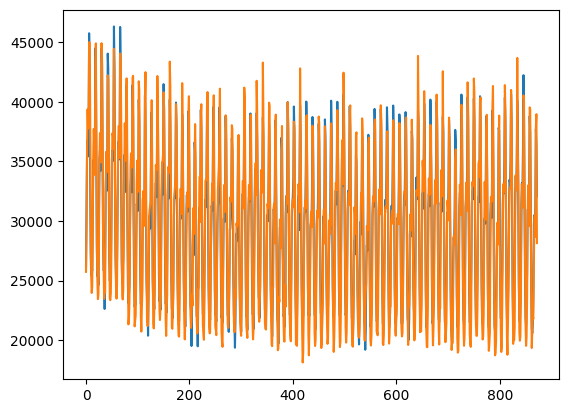

In [77]:
plt.plot(Y_test.values)
plt.plot(y_pred)
plt.show()